In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt

from core.datasets import *
from core.networks import *
from core.models import *

# Intializing Dataset and Models

In [3]:
device = torch.device('cuda:0')

batch_size = 8
n_workers = 4
shuffle = True

cae_latent_dim = 32
cae_stride = 2
resnet_model_no = 34

dir_data = '/Users/minha/Documents/Data/celeba/clean/'
dir_load = '../resources/models/'
path_metadata = '/Users/minha/Documents/Data/celeba/list_attr_celeba.csv'
features = ['Attractive', 'Bags_Under_Eyes', 'Bangs', 'Chubby', 'Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Smiling', 'Wearing_Lipstick', 'Young']

torch.cuda.empty_cache()

In [4]:
dataset = CelebA(dir_data, path_metadata, features)

Processing Labels...


100%|████████████████████████████████████████████████████████████████████████| 202599/202599 [00:58<00:00, 3448.13it/s]


In [5]:
train_len = int(len(dataset)*.8)
val_len = len(dataset) - train_len
print(train_len, val_len)

118251 29563


In [6]:
dataset_train = torch.utils.data.Subset(dataset, list(range(0, train_len)))
dataset_val = torch.utils.data.Subset(dataset, list(range(train_len, len(dataset))))

In [7]:
dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle, num_workers=n_workers)

In [8]:
x_shape = (3, 224, 224)
network_cae = ConvAutoencoder(cae_latent_dim, *x_shape, stride=cae_stride).to(device)
network_resnet = ResNet(34, len(features), in_channels=3).to(device)

In [9]:
model_cae = ModelCAE(network_cae)
model_cls = ModelSigmoidClassifier(network_resnet)

In [10]:
if dir_load is not None:
    model_cae.load(dir_load + 'cae.pth')
    model_cls.load(dir_load + 'cls.pth')

# Performance

In [11]:
dataiter = iter(dataloader)

In [12]:
idx, x, y = next(dataiter)
x = x.to(device)
y = y.to(device)

In [13]:
# cae
x_pred = model_cae.network(x)
mses = []
for i in range(batch_size):
    mse = torch.mean((x[i] - x_pred[i])**2)
    mses.append(float(mse))
img = x.permute(0, 2, 3, 1).to('cpu').numpy()
img_pred = x_pred.permute(0, 2, 3, 1).to('cpu').detach().numpy()

# cls
y_ = y.to('cpu').numpy().astype('int')
y_pred = torch.where(torch.sigmoid(model_cls.network(x)) > .5, 1, 0).to('cpu').numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


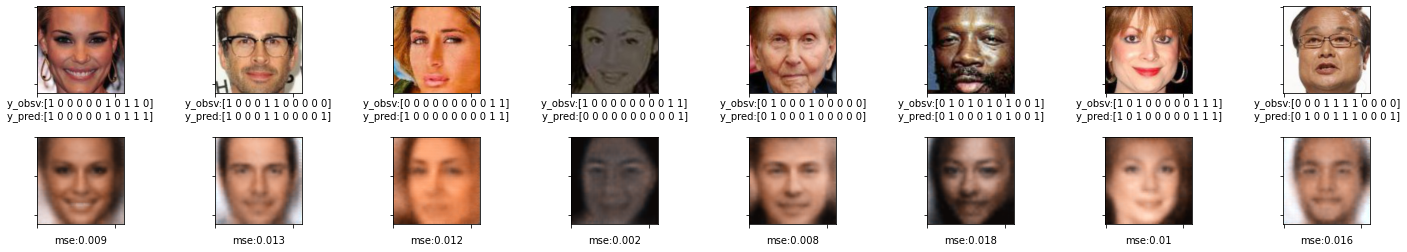

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=batch_size, sharex=True, sharey=True, figsize=(25,4))
fig.subplots_adjust(hspace=.5)
for j in range(batch_size):
    axes[0][j].imshow(img[j])
    axes[0][j].set_yticklabels([])
    axes[0][j].set_xticklabels([])
    axes[0][j].set_xlabel('y_obsv:' + str(y_[j]) + '\ny_pred:' + str(y_pred[j]))
    
    axes[1][j].imshow(img_pred[j])
    axes[1][j].set_yticklabels([])
    axes[1][j].set_xticklabels([])
    axes[1][j].set_xlabel('mse:' + str(round(mses[j], 3)))

In [15]:
print(features)

['Attractive', 'Bags_Under_Eyes', 'Bangs', 'Chubby', 'Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Smiling', 'Wearing_Lipstick', 'Young']
